In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
tree = pd.read_csv('tree.csv')
prf = pd.read_csv('prf.csv')

In [79]:
# Display the shape of sampled datasets
print(f'Tree Shape: {tree.shape}')


Tree Shape: (51156, 16)


In [3]:
# Display columns for each dataset
print("Columns in Tree Inventory Data:")
print(tree.columns)





# Display the first few rows of each dataset for context
print("\nFirst few rows of Tree Inventory Data:")
print(tree.head())




Columns in Tree Inventory Data:
Index(['_id', 'OBJECTID', 'STRUCTID', 'ADDRESS', 'STREETNAME', 'CROSSSTREET1',
       'CROSSSTREET2', 'SUFFIX', 'UNIT_NUMBER', 'TREE_POSITION_NUMBER', 'SITE',
       'WARD', 'BOTANICAL_NAME', 'COMMON_NAME', 'DBH_TRUNK', 'geometry'],
      dtype='object')

First few rows of Tree Inventory Data:
   _id  OBJECTID  STRUCTID  ADDRESS            STREETNAME       CROSSSTREET1  \
0    1         1  TO105087      145  ST GEORGE ST TORONTO  PRINCE ARTHUR AVE   
1   34        35   TO18965      330            CLINTON ST    NANCY POCOCK PL   
2   37        38   TO16750      161          CHAPLIN CRES          AVENUE RD   
3   48        49   TO37844     1669          GERRARD ST E    GAINSBOROUGH RD   
4   64        65   TO16574        9           CHANNEL AVE                NaN   

  CROSSSTREET2 SUFFIX  UNIT_NUMBER  TREE_POSITION_NUMBER SITE  WARD  \
0  LOWTHER AVE    NaN            0                  30.0  NaN  11.0   
1   CLINTON PL    NaN            0                

In [4]:
tree.columns

Index(['_id', 'OBJECTID', 'STRUCTID', 'ADDRESS', 'STREETNAME', 'CROSSSTREET1',
       'CROSSSTREET2', 'SUFFIX', 'UNIT_NUMBER', 'TREE_POSITION_NUMBER', 'SITE',
       'WARD', 'BOTANICAL_NAME', 'COMMON_NAME', 'DBH_TRUNK', 'geometry'],
      dtype='object')

In [5]:
tree.isnull().sum()

_id                         0
OBJECTID                    0
STRUCTID                    0
ADDRESS                     0
STREETNAME                  1
CROSSSTREET1             1574
CROSSSTREET2             2500
SUFFIX                  50749
UNIT_NUMBER                 0
TREE_POSITION_NUMBER        4
SITE                    49043
WARD                        1
BOTANICAL_NAME              0
COMMON_NAME                 0
DBH_TRUNK                   1
geometry                    0
dtype: int64

In [6]:
tree_cleaned = tree.drop(columns=['SUFFIX', 'SITE'])

In [7]:
from sklearn.impute import SimpleImputer

numerical_features = ['DBH_TRUNK']
imputer = SimpleImputer(strategy='mean')
tree_cleaned[numerical_features] = imputer.fit_transform(tree_cleaned[numerical_features])

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Fill missing values for categorical columns
categorical_features = ['STREETNAME', 'CROSSSTREET1', 'CROSSSTREET2', 'UNIT_NUMBER', 'TREE_POSITION_NUMBER', 'WARD', 'BOTANICAL_NAME', 'COMMON_NAME']
tree_cleaned[categorical_features] = tree_cleaned[categorical_features].fillna('Unknown')

# Convert categorical columns to numerical using one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [9]:
pip install lazypredict

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
tree_cleaned.columns

Index(['_id', 'OBJECTID', 'STRUCTID', 'ADDRESS', 'STREETNAME', 'CROSSSTREET1',
       'CROSSSTREET2', 'UNIT_NUMBER', 'TREE_POSITION_NUMBER', 'WARD',
       'BOTANICAL_NAME', 'COMMON_NAME', 'DBH_TRUNK', 'geometry'],
      dtype='object')

In [11]:
tree_cleaned.value_counts('DBH_TRUNK')

DBH_TRUNK
30.0     1871
40.0     1506
25.0     1419
20.0     1406
35.0     1277
         ... 
190.0       1
189.0       1
154.0       1
152.0       1
540.0       1
Name: count, Length: 174, dtype: int64

In [12]:
tree['is_in_need'] = (tree['DBH_TRUNK'] < 50).astype(int)  

# Prepare features and target
X = tree.drop(columns=['_id', 'OBJECTID', 'STRUCTID', 'ADDRESS', 'STREETNAME', 'CROSSSTREET1', 'CROSSSTREET2', 'UNIT_NUMBER', 'TREE_POSITION_NUMBER', 'WARD', 'BOTANICAL_NAME', 'COMMON_NAME', 'DBH_TRUNK', 'geometry', 'is_in_need'])
y = tree['is_in_need']

In [13]:
import numpy as np
tree['DBH_TRUNK_Squared'] = tree['DBH_TRUNK'] ** 2
tree['DBH_TRUNK_Log'] = tree['DBH_TRUNK'].apply(lambda x: np.log(x + 1))
tree['StreetName_Length'] = tree['STREETNAME'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
tree['Address_Has_CrossStreet'] = tree['CROSSSTREET1'].apply(lambda x: 1 if pd.notnull(x) else 0)

ward_avg_dbh = tree.groupby('WARD')['DBH_TRUNK'].transform('mean')
tree['Average_DBH_TRUNK_Per_Ward'] = ward_avg_dbh


ward_tree_count = tree.groupby('WARD')['OBJECTID'].transform('count')
tree['Number_of_Trees_Per_Ward'] = ward_tree_count


tree['Tree_Position_Indicator'] = tree['TREE_POSITION_NUMBER'].apply(lambda x: 1 if x > 0 else 0)


tree['DBH_TRUNK_X_Tree_Position'] = tree['DBH_TRUNK'] * tree['TREE_POSITION_NUMBER']

In [14]:
tree.columns

Index(['_id', 'OBJECTID', 'STRUCTID', 'ADDRESS', 'STREETNAME', 'CROSSSTREET1',
       'CROSSSTREET2', 'SUFFIX', 'UNIT_NUMBER', 'TREE_POSITION_NUMBER', 'SITE',
       'WARD', 'BOTANICAL_NAME', 'COMMON_NAME', 'DBH_TRUNK', 'geometry',
       'is_in_need', 'DBH_TRUNK_Squared', 'DBH_TRUNK_Log', 'StreetName_Length',
       'Address_Has_CrossStreet', 'Average_DBH_TRUNK_Per_Ward',
       'Number_of_Trees_Per_Ward', 'Tree_Position_Indicator',
       'DBH_TRUNK_X_Tree_Position'],
      dtype='object')

In [15]:
tree_cleaned.shape

(51156, 14)

C:\Users\NIRUP\AppData\Local\Temp\ipykernel_10776\1410200862.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\NIRUP\AppData\Local\Temp\ipykernel_10776\1410200862.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\NIRUP\AppData\Local\Temp\ipykernel_10776\1410200862.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

Model: RandomForest
              precision    recall  f1-score       support
0              1.000000  0.999792  0.999896   4797.000000
1              0.999875  1.000000  0.999937   7992.000000
accuracy       0.999922  0.999922  0.999922      0.999922
macro avg      0.999937  0.999896  0.999917  12789.000000
weighted avg   0.999922  0.999922  0.999922  12789.000000


Model: LogisticRegression
              precision    recall  f1-score       support
0              0.992133  0.998958  0.995533   4797.000000
1              0.999372  0.995245  0.997304   7992.000000
accuracy       0.996638  0.996638  0.996638      0.996638
macro avg      0.995752  0.997101  0.996419  12789.000000
weighted avg   0.996656  0.996638  0.996640  12789.000000


Model: SVC
              precision    recall  f1-score      support
0              1.000000  0.388785  0.559892   4797.00000
1              0.731600  1.000000  0.844999   7992.00000
accuracy       0.770740  0.770740  0.770740      0.77074
macro avg      

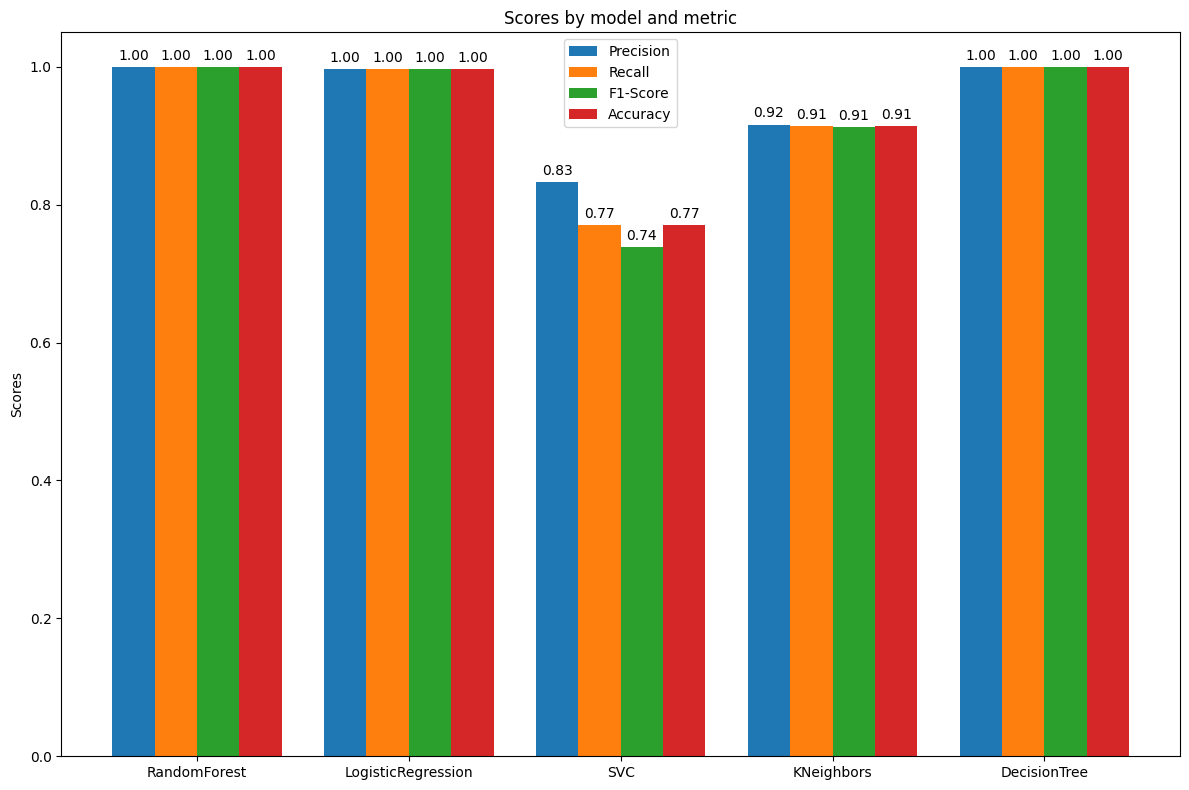

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x00000255CE107190>


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from shapash.explainer.smart_explainer import SmartExplainer

# Prepare your dataset
target_column = 'is_in_need'
features = [col for col in tree.columns if col not in [target_column, 'geometry']]  # Drop target and non-numeric columns
X = tree[features]
y = tree[target_column]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Handle missing values for numeric columns
numeric_imputer = SimpleImputer(strategy='median')
X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

# Handle missing values for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# Frequency encoding for categorical columns
for col in categorical_cols:
    freq = X[col].value_counts()
    X[col] = X[col].map(freq)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# List of classifiers to test
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

# Dictionary to store classification reports and accuracy
results = {}
accuracies = []

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    report = classification_report(y_test, predictions, output_dict=True)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)
    results[name] = pd.DataFrame(report).transpose()

# Display the reports in a table format
for model_name, report_df in results.items():
    print(f"Model: {model_name}")
    print(report_df)
    print("\n")

# Plotting the results
metrics = ['precision', 'recall', 'f1-score', 'support']
avg_metrics = ['precision', 'recall', 'f1-score']

# Prepare data for plotting
plot_data = {metric: [] for metric in avg_metrics}
plot_data['accuracy'] = accuracies

for model_name in classifiers.keys():
    for metric in avg_metrics:
        plot_data[metric].append(results[model_name].loc['weighted avg'][metric])

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(classifiers))
width = 0.2

# Plotting each metric
rects1 = ax.bar(x - 1.5*width, plot_data['precision'], width, label='Precision')
rects2 = ax.bar(x - 0.5*width, plot_data['recall'], width, label='Recall')
rects3 = ax.bar(x + 0.5*width, plot_data['f1-score'], width, label='F1-Score')
rects4 = ax.bar(x + 1.5*width, plot_data['accuracy'], width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(classifiers.keys())
ax.legend()

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()

# Choose a model for Shapash (e.g., RandomForestClassifier)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Shapash explainer
xpl = SmartExplainer(model=model)
y_pred_series = pd.Series(model.predict(X_test), index=X_test.index)
xpl.compile(x=X_test, y_pred=y_pred_series)

# Plot feature importance
xpl.plot.features_importance()

# Plot contribution for each feature
for col in X_test.columns:
    xpl.plot.contribution_plot(col)

C:\Users\NIRUP\AppData\Local\Temp\ipykernel_10776\1912560904.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\NIRUP\AppData\Local\Temp\ipykernel_10776\1912560904.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\NIRUP\AppData\Local\Temp\ipykernel_10776\1912560904.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

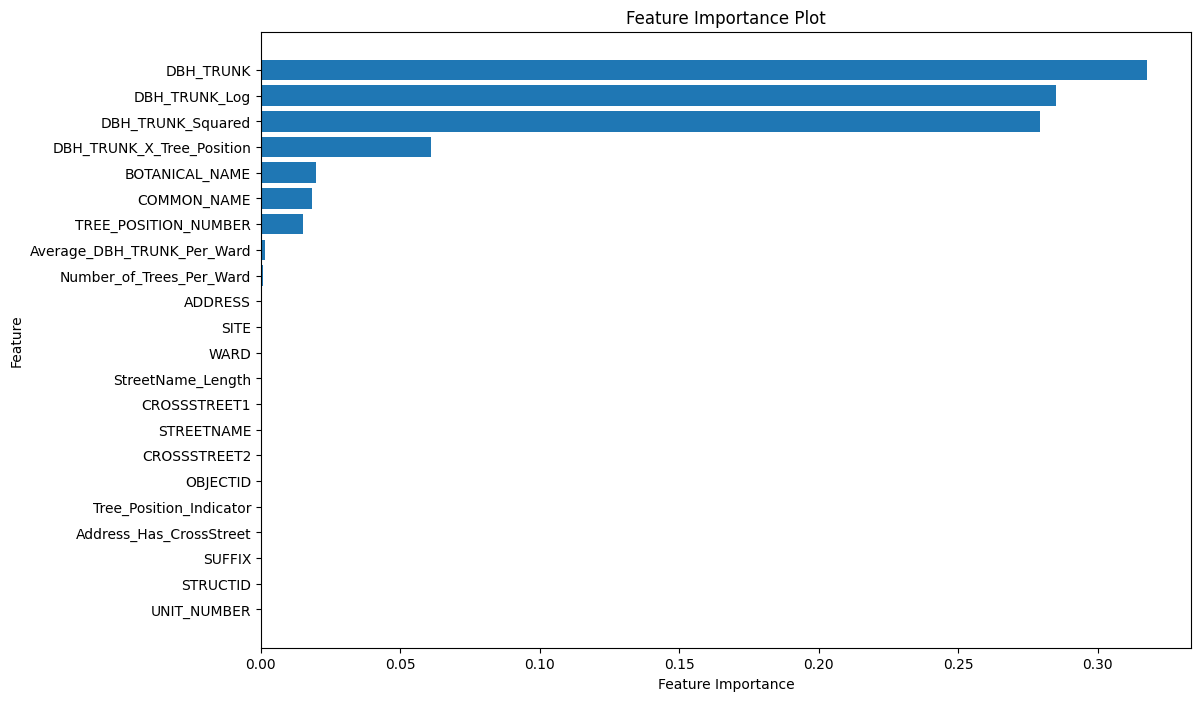

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming 'tree' is your DataFrame
# Prepare your dataset
target_column = 'is_in_need'
features = [col for col in tree.columns if col not in [target_column, 'geometry', '_id']]  # Drop target, non-numeric columns, and unique ID
X = tree[features]
y = tree[target_column]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Handle missing values for numeric columns
numeric_imputer = SimpleImputer(strategy='median')
X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

# Handle missing values for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# Frequency encoding for categorical columns
for col in categorical_cols:
    freq = X[col].value_counts()
    X[col] = X[col].map(freq)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for the feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()